# Lunar Lander - Rainbow DQN

In [2]:
import os
import time
from abc import ABC, abstractmethod
from enum import Enum
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

from IPython.display import clear_output

%pip install swig
%pip install "gymnasium[box2d]"

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Agent-related Class Definitions

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class RainbowDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(RainbowDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_vals = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_vals

class DQNAgent:
    BATCH_SIZE = 32
    EPSILON_START = 1
    EPSILON_CUTOFF = 0.05
    EPSILON_DECAY = 100000
    GAMMA = 0.99
    LR = 1e-4
    MEMORY_SIZE = 10000
    total_steps = 0

    def __init__(self, state_dim, action_dim):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.memory = ReplayBuffer(self.MEMORY_SIZE)
        self.steps_done = 0
        self.epsilon = self.EPSILON_START

    def select_e_greedy_action(self, env, state):
        if random.random() < self.epsilon:
            return random.randint(0, env.action_space.n - 1)
        else:
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                return self.policy_net(state).argmax(dim=1).item()

    def select_greedy_action(self, state):
      state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
      with torch.no_grad():
          return self.policy_net(state).argmax(dim=1).item()

    def decay_epsilon(self):
      self.total_steps += 1
      self.epsilon = max(self.EPSILON_CUTOFF, self.EPSILON_START - (self.total_steps / self.EPSILON_DECAY))

    def train(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        batch = self.memory.sample(self.BATCH_SIZE)

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device).unsqueeze(1)
        current_q = self.policy_net(states).gather(1, actions)
        next_q = self.target_net(next_states).max(1, keepdim=True)[0].detach()
        target_q = rewards + (self.GAMMA * next_q * (1 - dones))

        loss = F.mse_loss(target_q, current_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

class RainbowDQNAgent(DQNAgent):
    TARGET_UPDATE_RATE = 0.05  # Like DoubleDQNAgent

    def __init__(self, state_dim, action_dim):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = RainbowDQN(state_dim, action_dim).to(self.device)
        self.target_net = RainbowDQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.memory = ReplayBuffer(self.MEMORY_SIZE)
        self.steps_done = 0
        self.epsilon = self.EPSILON_START

    def train(self):
        if len(self.memory) < self.BATCH_SIZE:
            return

        batch = self.memory.sample(self.BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device).unsqueeze(1)

        with torch.no_grad():
            best_actions = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q = self.target_net(next_states).gather(1, best_actions)
            target_q = rewards + self.GAMMA * next_q * (1 - dones)

        current_q = self.policy_net(states).gather(1, actions)

        loss = F.mse_loss(target_q, current_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            new_params = self.TARGET_UPDATE_RATE * policy_param.data + (1.0 - self.TARGET_UPDATE_RATE) * target_param.data
            target_param.data.copy_(new_params)

## Training Function Definition

In [6]:
def train_q_values_ddqn(env, env_name,target_update_interval = 10, training_episodes = 1000, agent_class = RainbowDQNAgent):
  MAX_STEPS = 1000
  CONVERGENCE_REWARD_COUNT = 20
  CONVERGENCE_MIN_REWARD = 270

  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n
  agent = agent_class(state_dim, action_dim)
  rewards_per_episode = []
  episode_times = []
  steps_per_episode = []
  epsilon_values = []
    
  for episode in range(training_episodes):
    start_time = time.time()
    obs, _ = env.reset()
    state = obs
    total_reward = 0
    done = False
    steps_taken = 0
    episode_transitions = []

    epsilon_values.append(agent.epsilon)

    while not done and steps_taken < MAX_STEPS:
        action = agent.select_e_greedy_action(env, state)
        obs, reward, done, _, _ = env.step(action)
        next_state = np.array(obs, dtype=np.float32)
        episode_transitions.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        steps_taken += 1

        agent.decay_epsilon()

    average_rewards_over_last_episodes = np.mean(rewards_per_episode[-CONVERGENCE_REWARD_COUNT:])
      
    if average_rewards_over_last_episodes >= CONVERGENCE_MIN_REWARD and total_reward >= CONVERGENCE_MIN_REWARD:
        print("Early stopping condition met! Stopping training.")
        print(f"Episode {episode + 1:}: Total Reward: {total_reward:.3f}, Steps: {steps_taken}, Time: {episode_time:.2f}s")
        break
    
    for transition in episode_transitions:
        agent.memory.push(*transition)
        agent.update_target_network()

    for _ in range(len(episode_transitions)):
        agent.train()

    end_time = time.time()
    episode_time = end_time - start_time
    episode_times.append(episode_time)
    rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps_taken)

    if episode % 10 == 0:
      print(f"Episode {episode + 1:}: Total Reward: {total_reward:.3f}, Epsilon: {agent.epsilon:.3f}, Steps: {steps_taken}, Time: {episode_time:.2f}s")

    if episode % 100 == 0:
      checkpoint = {
        'policy_net_state_dict': agent.policy_net.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'total_steps': agent.total_steps,
        'rewards_per_episode': rewards_per_episode,
        'epsilon_values': epsilon_values,
        'episode_times': episode_times,
        'steps_per_episode': steps_per_episode
      }

      torch.save(checkpoint, "rainbow_lunar_lander_v3_checkpoint.pth")
      torch.save(agent.policy_net.state_dict(), "rainbow_lunar_lander_v3.pth")
      print("Checkpoint Reached!")

  return agent, rewards_per_episode, epsilon_values, episode_times, steps_per_episode

## LunarLander-v3 - Training

In [8]:
env_name = "LunarLander-v3"
lunar_env = gym.make(env_name)

trained_agent, rewards_per_episode, epsilon_values, episode_times, steps_per_episode = train_q_values_ddqn(lunar_env, env_name, training_episodes = 3000)

checkpoint = {
    'policy_net_state_dict': trained_agent.policy_net.state_dict(),
    'optimizer_state_dict': trained_agent.optimizer.state_dict(),
    'total_steps': trained_agent.total_steps,
    'rewards_per_episode': rewards_per_episode,
    'epsilon_values': epsilon_values,
    'episode_times': episode_times,
    'steps_per_episode': steps_per_episode
}

torch.save(checkpoint, "rainbow_lunar_lander_v3_checkpoint.pth")
torch.save(trained_agent.policy_net.state_dict(), "rainbow_lunar_lander_v3.pth")

C:\Users\viswa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\viswa\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode 1: Total Reward: -261.468, Epsilon: 0.999, Steps: 125, Time: 0.42s
Checkpoint Reached!
Episode 11: Total Reward: -420.423, Epsilon: 0.990, Steps: 91, Time: 0.34s
Episode 21: Total Reward: -42.335, Epsilon: 0.981, Steps: 87, Time: 0.34s
Episode 31: Total Reward: -20.134, Epsilon: 0.973, Steps: 86, Time: 0.35s
Episode 41: Total Reward: -115.913, Epsilon: 0.963, Steps: 168, Time: 0.66s
Episode 51: Total Reward: -149.665, Epsilon: 0.952, Steps: 117, Time: 0.47s
Episode 61: Total Reward: -124.504, Epsilon: 0.944, Steps: 78, Time: 0.37s
Episode 71: Total Reward: -70.543, Epsilon: 0.935, Steps: 61, Time: 0.25s
Episode 81: Total Reward: -98.537, Epsilon: 0.926, Steps: 100, Time: 0.40s
Episode 91: Total Reward: -103.059, Epsilon: 0.917, Steps: 77, Time: 0.30s
Episode 101: Total Reward: -110.110, Epsilon: 0.909, Steps: 69, Time: 0.27s
Checkpoint Reached!
Episode 111: Total Reward: -115.137, Epsilon: 0.900, Steps: 88, Time: 0.34s
Episode 121: Total Reward: -119.647, Epsilon: 0.891, Steps:

## Training Results

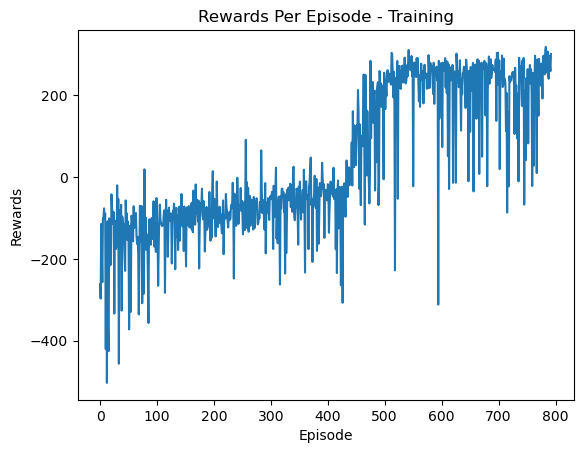

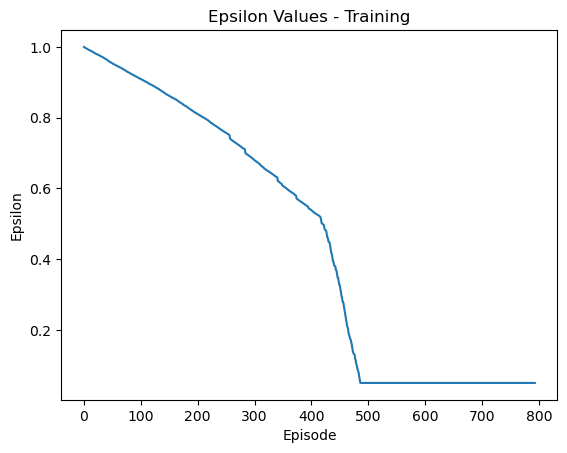

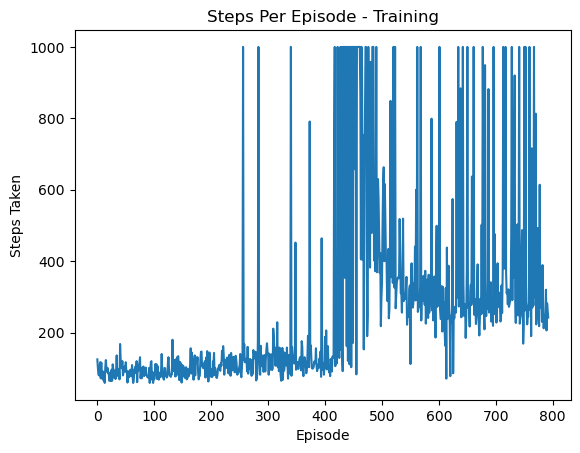

In [10]:
results = torch.load("rainbow_lunar_lander_v3_checkpoint.pth", weights_only=False)

rewards_per_episode = results["rewards_per_episode"]
epsilon_values = results["epsilon_values"]
steps_per_episode = results["steps_per_episode"]

plt.plot(rewards_per_episode)
plt.title("Rewards Per Episode - Training")
plt.xlabel("Episode")
plt.ylabel("Rewards")

plt.show()

plt.plot(epsilon_values)
plt.title("Epsilon Values - Training")
plt.xlabel("Episode")
plt.ylabel("Epsilon")

plt.show()

plt.plot(steps_per_episode)
plt.title("Steps Per Episode - Training")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")

plt.show()

## LunarLander-v3 - Evaluation

Episode 1: Total Reward = 165.55673813925313, Steps taken: 1000
Episode 2: Total Reward = 304.79532471192306, Steps taken: 235
Episode 3: Total Reward = 262.1577210664723, Steps taken: 232
Episode 4: Total Reward = 284.25893827554864, Steps taken: 285
Episode 5: Total Reward = 295.7307494588898, Steps taken: 225
Episode 6: Total Reward = 228.52527821354522, Steps taken: 272
Episode 7: Total Reward = 281.1959957597761, Steps taken: 224
Episode 8: Total Reward = 284.92767417507264, Steps taken: 237
Episode 9: Total Reward = 313.43242587725126, Steps taken: 195
Episode 10: Total Reward = 283.86618039238135, Steps taken: 245

Average reward over 10 episodes: 270.4447026070114
Average steps taken over 10 episodes: 315.0



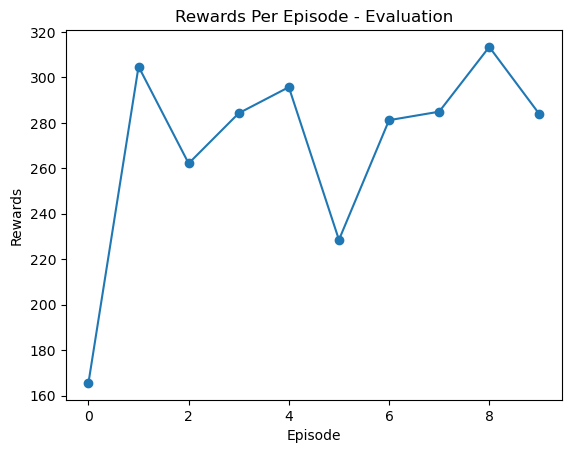

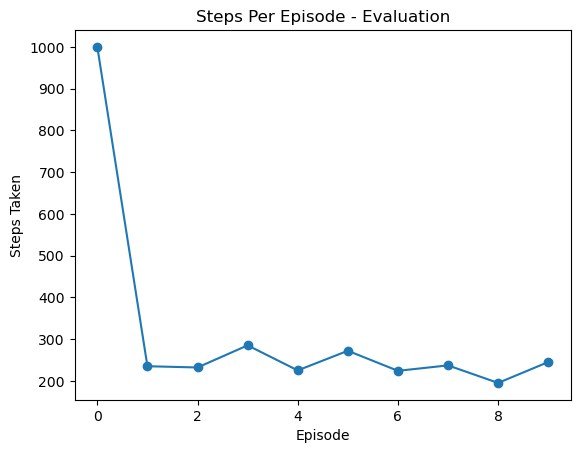

In [12]:
steps_arr = []
rewards_arr = []

env_name = "LunarLander-v3"
lunar_env = gym.make(env_name)

state_dim = lunar_env.observation_space.shape[0]
action_dim = lunar_env.action_space.n

trained_agent = RainbowDQNAgent(state_dim, action_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_agent.policy_net.load_state_dict(torch.load("rainbow_lunar_lander_v3.pth", map_location=device, weights_only=True))

for episode in range(10):
    obs, _ = lunar_env.reset()
    state = obs
    tot_reward = 0
    episode_over = False
    steps_taken = 0
    
    while not episode_over:
        with torch.no_grad():
            action = trained_agent.select_greedy_action(state)
        obs, reward, done, truncated, _ = lunar_env.step(action)
        episode_over = done or truncated
        state = np.array(obs, dtype=np.float32)
        steps_taken +=1
        tot_reward += reward
    rewards_arr.append(tot_reward)
    steps_arr.append(steps_taken)
    print(f"Episode {episode + 1}: Total Reward = {tot_reward}, Steps taken: {steps_taken}")

print(f"\nAverage reward over 10 episodes: {np.mean(rewards_arr)}")
print(f"Average steps taken over 10 episodes: {np.mean(steps_arr)}\n")

plt.plot(rewards_arr, marker="o")
plt.title("Rewards Per Episode - Evaluation")
plt.xlabel("Episode")
plt.ylabel("Rewards")

plt.show()

plt.plot(steps_arr, marker="o")
plt.title("Steps Per Episode - Evaluation")
plt.xlabel("Episode")
plt.ylabel("Steps Taken")

plt.show()